In [1]:
import pandas as pd
import requests
import io
from typing import Optional

STOOQ_DAILY_URL = "https://stooq.com/q/d/l/?s={symbol}&i=d"

def fetch_stooq_daily(symbol: str, timeout: int = 30) -> Optional[pd.DataFrame]:
    """
    Fetch daily OHLCV from Stooq for a given symbol.
    Returns a cleaned DataFrame or None if fails.
    """
    url = STOOQ_DAILY_URL.format(symbol=symbol.lower())
    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        if not r.text.strip():
            return None
        df = pd.read_csv(io.StringIO(r.text))
        if df.empty:
            return None
        df.columns = [c.lower() for c in df.columns]
        df['date'] = pd.to_datetime(df['date']).dt.tz_localize('UTC')
        df['timestamp'] = df['date'].view('int64')
        for col in ['open','high','low','close','volume']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.sort_values('date').reset_index(drop=True)
        df['symbol'] = symbol.lower()
        return df
    except Exception as e:
        print(f"[fetch_stooq_daily] failed for {symbol}: {e}")
        return None

In [2]:
import matplotlib
print(matplotlib.get_data_path())  # <-- works in most versions


C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\mpl-data


In [3]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data/csv")

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def canonicalize_and_write_csv(symbol: str, df: pd.DataFrame, out_dir: Path = DATA_DIR):
    ensure_dir(out_dir)
    dfc = df.copy()
    if 'timestamp' not in dfc.columns and 'date' in dfc.columns:
        dfc['timestamp'] = pd.to_datetime(dfc['date']).view('int64')
    cols = ['timestamp','date','symbol','open','high','low','close','volume']
    for c in cols:
        if c not in dfc.columns:
            dfc[c] = pd.NA
    dfc = dfc[cols]
    out_path = out_dir / f"{symbol.lower()}.csv"
    dfc.to_csv(out_path, index=False)
    print(f"Wrote {out_path} rows={len(dfc)}")
    return out_path

def fetch_and_store_csv(symbols, out_dir: Path = DATA_DIR):
    results = {}
    for s in symbols:
        print(f"Fetching {s} ...")
        df = fetch_stooq_daily(s)
        if df is None:
            print(f"  no data for {s}")
            results[s] = None
            continue
        p = canonicalize_and_write_csv(s, df, out_dir=out_dir)
        results[s] = p
    return results

if __name__ == "__main__":
    symbols = ["MAR.us", "PANW.us"]
    fetch_and_store_csv(symbols)


Fetching MAR.us ...
Wrote data\csv\mar.us.csv rows=8017
Fetching PANW.us ...
Wrote data\csv\panw.us.csv rows=3290


Symbol: KO.US Range: 1970-01-02 -> 2025-08-14 Rows: 14023
Business day coverage: 14023/14510 missing_frac=0.034


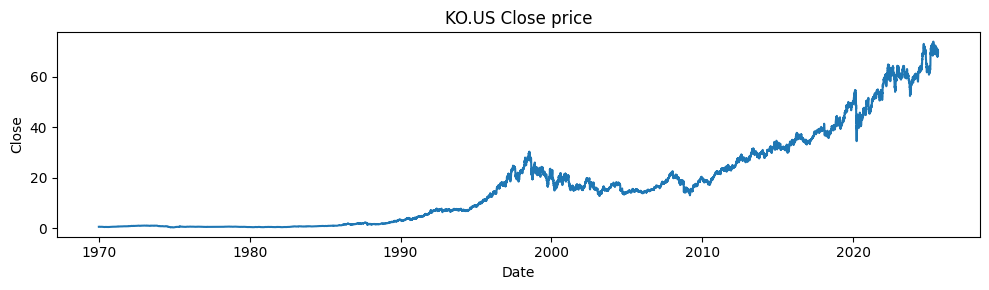

Symbol: KO.US (Weekly) Range: 1970-01-04 -> 2025-08-17 Rows: 2903
Business day coverage: 0/14510 missing_frac=1.000


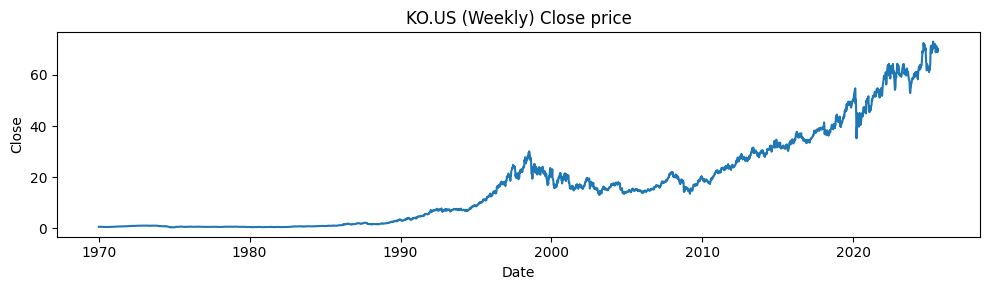

Symbol: KO.US (Daily) Range: 1970-01-02 -> 2025-08-14 Rows: 14023
Business day coverage: 14023/14510 missing_frac=0.034


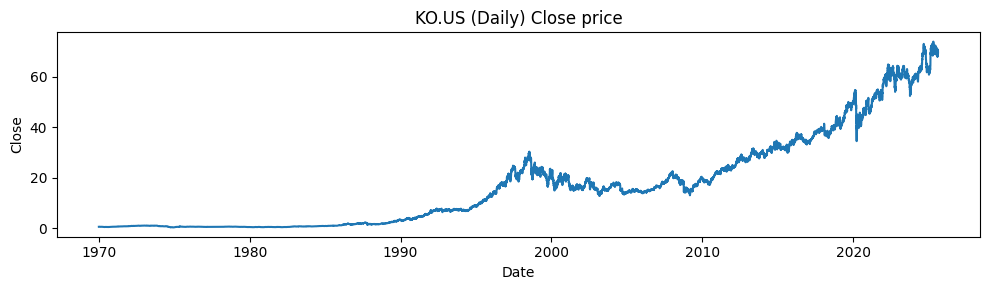

In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

def load_csv_symbol(path: Path) -> pd.DataFrame:
    """Load CSV and parse dates."""
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").reset_index(drop=True)
    if "symbol" not in df.columns:
        df["symbol"] = path.stem.lower()
    return df

def daily_sanity_report(df: pd.DataFrame, symbol: str = None):
    """Print basic info and plot close price."""
    first = df['date'].min()
    last = df['date'].max()
    print(f"Symbol: {symbol} Range: {first.date()} -> {last.date()} Rows: {len(df)}")
    all_days = pd.date_range(first.date(), last.date(), freq='B')
    missing = set(all_days.date) - set(df['date'].dt.date)
    miss_frac = len(missing) / len(all_days)
    print(f"Business day coverage: {len(all_days)-len(missing)}/{len(all_days)} missing_frac={miss_frac:.3f}")

    plt.figure(figsize=(10,3))
    plt.plot(df['date'], df['close'])
    plt.title(f"{symbol or ''} Close price")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.tight_layout()
    plt.show()

def resample_to_frequency(df: pd.DataFrame, freq="W") -> pd.DataFrame:
    """Resample OHLCV to a new frequency (W = weekly, M = monthly)."""
    df_resampled = df.set_index("date").resample(freq).agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
    }).dropna().reset_index()
    return df_resampled

df = load_csv_symbol(Path("data/csv/KO.us.csv"))
daily_sanity_report(df, "KO.US")

df_weekly = resample_to_frequency(df, freq="W")
daily_sanity_report(df_weekly, "KO.US (Weekly)")

df_daily = resample_to_frequency(df, freq="D")
daily_sanity_report(df_daily, "KO.US (Daily)")

In [5]:
import pandas as pd
from pathlib import Path
import numpy as np

DATA_DIR = Path("data/csv")
tickers = ['AVGO.us', 'BSX.us','HWM.us','MAR.us','PANW.us','NXPI.us','AMAT.us']

# Define 10-year window (tz-naive)
end_date = pd.Timestamp.today().tz_localize(None)
start_date = end_date - pd.DateOffset(years=10)

# Load CSVs, align by date, and filter last 10 years
price_dict = {}
for t in tickers:
    df = pd.read_csv(DATA_DIR / f"{t}.csv", parse_dates=["date"])
    df = df.sort_values("date")
    # Remove timezone if exists
    df["date"] = df["date"].dt.tz_localize(None)
    # Filter last 10 years
    df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
    price_dict[t] = df.set_index("date")["close"]

# Combine into single DataFrame
prices = pd.DataFrame(price_dict)
prices = prices.ffill().bfill()  # fill missing values

# Log prices
log_prices = np.log(prices)
log_prices.head()


,AVGO.us,BSX.us,HWM.us,MAR.us,PANW.us,NXPI.us,AMAT.us
date,,,,,,,
2015-08-21,2.161775,2.794228,2.685293,4.170092,3.277084,4.324305,2.644471
2015-08-24,2.148160,2.763170,2.685293,4.131266,3.251730,4.310873,2.619780
2015-08-25,2.135126,2.758743,2.685293,4.129316,3.273364,4.330610,2.602267
2015-08-26,2.203547,2.795450,2.685293,4.178565,3.331904,4.381025,2.628769
2015-08-27,2.286661,2.829678,2.685293,4.195444,3.330897,4.399919,2.673728


In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen test requires no missing values
log_prices_clean = log_prices.dropna()

# Run Johansen test
result = coint_johansen(log_prices_clean, det_order=0, k_ar_diff=1)

# Trace statistic and critical values
trace_stat = result.lr1  # trace statistics
crit_values = result.cvt[:,1]  # 5% significance

# Check which cointegration relationships are significant
for i, (ts, cv) in enumerate(zip(trace_stat, crit_values)):
    print(f"Eigenvalue {i}: Trace stat={ts:.2f}, 5% crit={cv:.2f}, Significant={ts>cv}")


Eigenvalue 0: Trace stat=157.55, 5% crit=125.62, Significant=True
Eigenvalue 1: Trace stat=86.35, 5% crit=95.75, Significant=False
Eigenvalue 2: Trace stat=51.75, 5% crit=69.82, Significant=False
Eigenvalue 3: Trace stat=32.19, 5% crit=47.85, Significant=False
Eigenvalue 4: Trace stat=16.68, 5% crit=29.80, Significant=False
Eigenvalue 5: Trace stat=4.35, 5% crit=15.49, Significant=False
Eigenvalue 6: Trace stat=0.17, 5% crit=3.84, Significant=False



Pair: AVGO.us & BSX.us
Hedge ratio (beta): 1.8948
ADF Statistic: -2.9305, p-value: 0.0419
Cointegrated
Half-life: 99.87 days


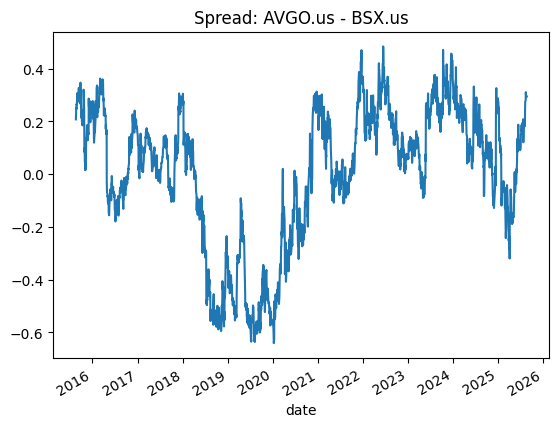


Pair: AVGO.us & HWM.us
Hedge ratio (beta): 1.2309
ADF Statistic: -3.3566, p-value: 0.0125
Cointegrated
Half-life: 85.37 days


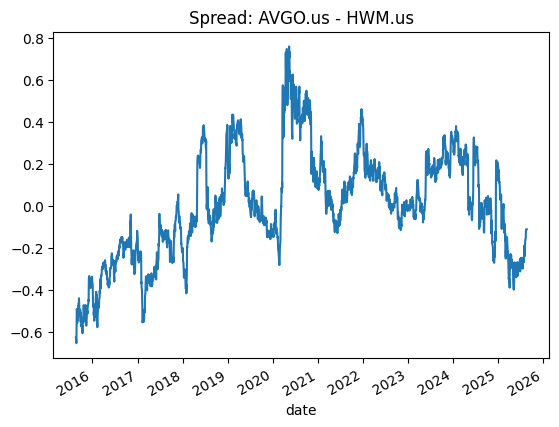


Pair: AMAT.us & NXPI.us
Hedge ratio (beta): 1.8105
ADF Statistic: -4.6061, p-value: 0.0001
Cointegrated
Half-life: 39.44 days


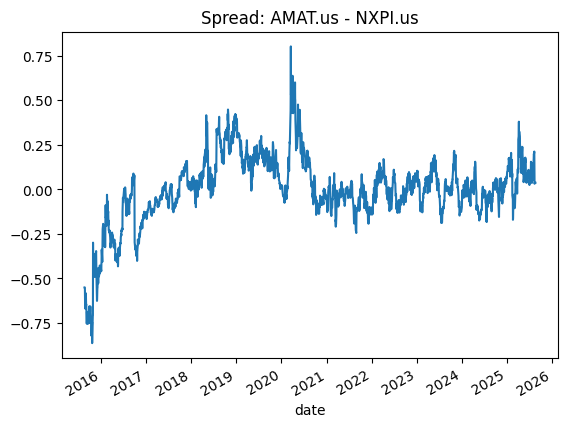


Pair: MAR.us & PANW.us
Hedge ratio (beta): 0.5235
ADF Statistic: -3.1336, p-value: 0.0242
Cointegrated
Half-life: 97.61 days


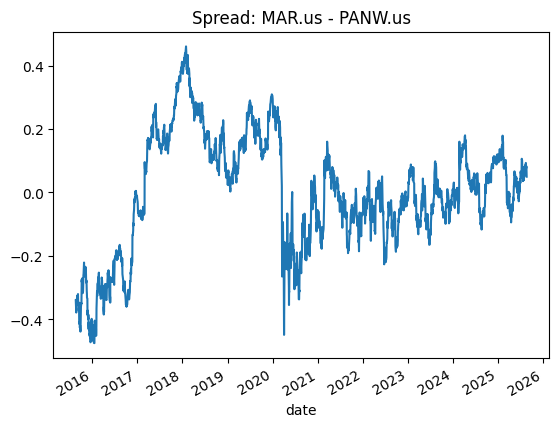


Summary of all pairs:
              Pair      Beta  ADF_pvalue  Cointegrated  Half_life
0   AVGO.us-BSX.us  1.894793    0.041913          True  99.874876
1   AVGO.us-HWM.us  1.230908    0.012530          True  85.371270
2  AMAT.us-NXPI.us  1.810468    0.000126          True  39.444969
3   MAR.us-PANW.us  0.523546    0.024166          True  97.612663


In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy.linalg import lstsq
import matplotlib.pyplot as plt

# List of pairs
pairs = [
    ('AVGO.us', 'BSX.us'),
    ('AVGO.us', 'HWM.us'),
    ('AMAT.us', 'NXPI.us'),
    ('MAR.us', 'PANW.us')
]

# Store results
results = []

for Y_col, X_col in pairs:
    Y = log_prices[Y_col]
    X = log_prices[X_col]
    
    # Step 1: Hedge ratio via OLS
    X_const = sm.add_constant(X)
    model = sm.OLS(Y, X_const).fit()
    alpha, beta = model.params
    print(f"\nPair: {Y_col} & {X_col}")
    print(f"Hedge ratio (beta): {beta:.4f}")
    
    # Step 2: Compute spread
    spread = Y - (alpha + beta * X)
    
    # Step 3: ADF test
    adf_result = adfuller(spread)
    print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
    cointegrated = adf_result[1] < 0.05
    print("Cointegrated" if cointegrated else "Not cointegrated")
    
    # Step 4: Half-life
    spread_lag = spread.shift(1).dropna()
    delta = (spread - spread_lag).dropna()
    spread_lag = spread_lag[delta.index]
    lambda_ = lstsq(spread_lag.values.reshape(-1,1), delta.values, rcond=None)[0][0]
    half_life = -np.log(2) / lambda_
    print(f"Half-life: {half_life:.2f} days")
    
    # Optional: Plot spread
    spread.plot(title=f"Spread: {Y_col} - {X_col}")
    plt.show()
    
    # Save results
    results.append({
        'Pair': f"{Y_col}-{X_col}",
        'Beta': beta,
        'ADF_pvalue': adf_result[1],
        'Cointegrated': cointegrated,
        'Half_life': half_life
    })

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\nSummary of all pairs:")
print(results_df)


Phase 3

In [8]:
pip install arch


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\91983\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
# -----------------------------
# Imports
# -----------------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# -----------------------------
# Parameters
# -----------------------------
pairs = [
    ('AVGO.us', 'BSX.us'),
    ('AVGO.us', 'HWM.us'),
    ('AMAT.us', 'NXPI.us'),
    ('MAR.us', 'PANW.us')
]

rolling_window = 20         # z-score window
entry_z = 2.0               # entry threshold in z
exit_z = 0.0                # exit threshold in z
kalman_delta = 1e-4         # process noise scale for Kalman (smaller -> smoother)
kalman_obs_var = None       # if None it is estimated from OLS residuals
arima_order = (1,0,0)       # simple AR(1) default, change if desired
garch_pq = (1,1)            # GARCH(p,q)
min_samples_for_models = 90 # minimum points to attempt ARIMA/GARCH
target_vol = 0.01           # desired daily vol per pair (fraction of portfolio)
max_leverage = 2.0          # cap size multiplier


In [10]:
import numpy as np
import pandas as pd

def kalman_alpha_beta(y, x, delta=1e-4, obs_var=1.0):
    """
    Kalman filter for Y_t = alpha_t + beta_t * X_t + eps_t
    Returns: beta_series, alpha_series
    - delta: process noise scale (higher -> faster adaptation)
    - obs_var: observation noise variance
    """
    y = y.astype(float)
    x = x.astype(float)

    # State: [alpha, beta]
    state_mean = np.zeros(2)
    state_cov  = np.eye(2)

    # Process noise (random walk for both alpha, beta)
    trans_cov = (delta / (1.0 - delta)) * np.eye(2)

    betas, alphas = [], []

    for t in range(len(y)):
        H = np.array([[1.0, x.iloc[t]]])                  # observation matrix
        # Predict
        state_cov_pred  = state_cov + trans_cov           # mean unchanged (random walk)
        state_mean_pred = state_mean

        # Innovations
        innov      = y.iloc[t] - (H @ state_mean_pred)
        innov_cov  = H @ state_cov_pred @ H.T + obs_var
        K          = state_cov_pred @ H.T @ np.linalg.inv(innov_cov)

        # Update
        state_mean = (state_mean_pred + (K.flatten() * innov)).reshape(2,)
        state_cov  = state_cov_pred - K @ H @ state_cov_pred

        alphas.append(state_mean[0])
        betas.append(state_mean[1])

    return pd.Series(betas, index=y.index), pd.Series(alphas, index=y.index)


              Pair    ADF_pvalue  Cointegrated  Half_life
0   AVGO.us-BSX.us  3.069526e-14          True  12.269448
1   AVGO.us-HWM.us  7.304795e-13          True  14.120565
2  AMAT.us-NXPI.us  5.427333e-18          True   9.580588
3   MAR.us-PANW.us  1.746472e-10          True  13.357840


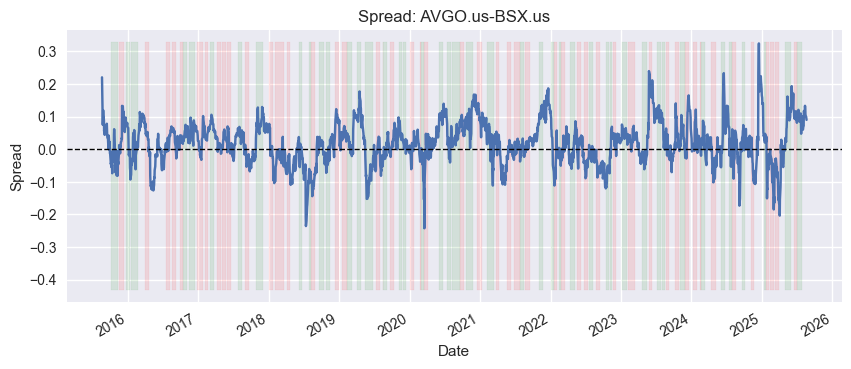

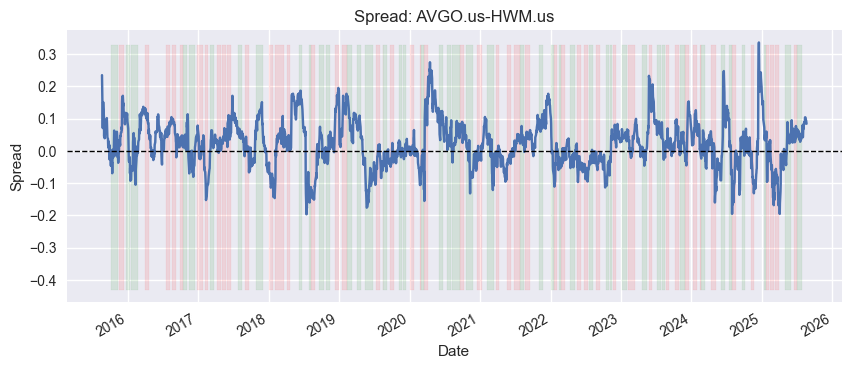

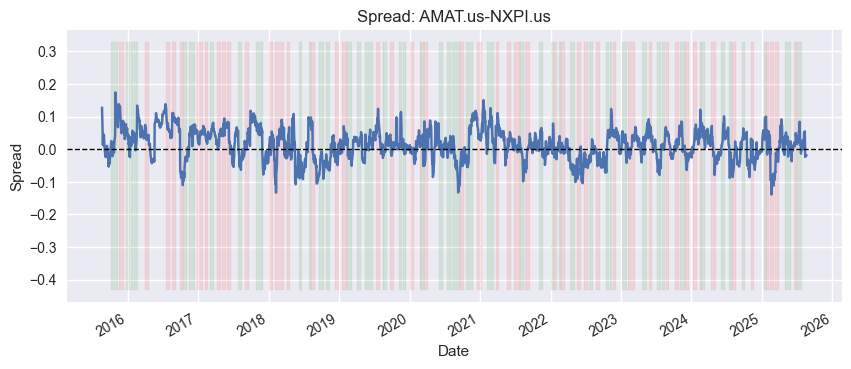

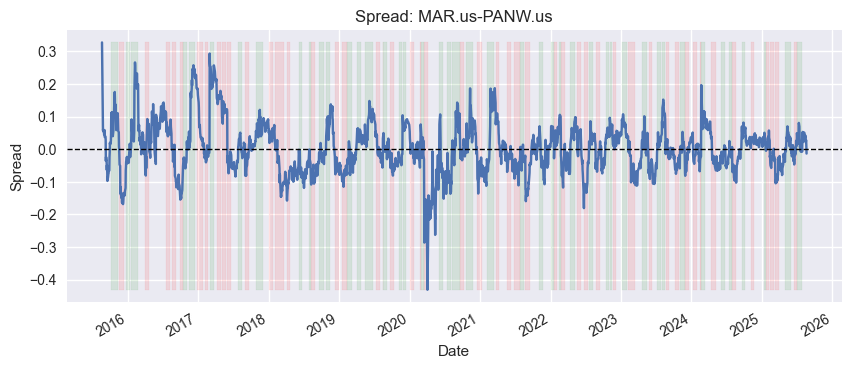

In [11]:
results = []

for Y_col, X_col in pairs:
    Y = log_prices[Y_col]
    X = log_prices[X_col]

    # Dynamic alpha & beta via Kalman filter
    beta_series, alpha_series = kalman_alpha_beta(Y, X, delta=1e-4, obs_var=1.0)

    # Spread with both alpha and beta
    spread = Y - (alpha_series + beta_series * X)

    # ADF test for stationarity
    adf_result = adfuller(spread.dropna())
    cointegrated = adf_result[1] < 0.05

    # Half-life of mean reversion
    spread_lag = spread.shift(1).dropna()
    delta_spread = (spread - spread_lag).dropna()
    spread_lag = spread_lag[delta_spread.index]
    lambda_ = np.linalg.lstsq(spread_lag.values.reshape(-1, 1), delta_spread.values, rcond=None)[0][0]
    half_life = -np.log(2) / lambda_ if lambda_ < 0 else np.nan
    signal_horizon = int(np.round(half_life)) if not np.isnan(half_life) else 5

    # Z-score calculation
    z_score = (spread - spread.rolling(rolling_window).mean()) / spread.rolling(rolling_window).std()

    # Trading signals
    long_signal = z_score < -entry_z
    short_signal = z_score > entry_z
    exit_signal = (z_score > -exit_z) & (z_score < exit_z)

    position = pd.Series(0, index=spread.index)
    for t in range(len(spread)):
        if long_signal.iloc[t]:
            end_idx = min(t + signal_horizon, len(spread))
            position.iloc[t:end_idx] = 1
        elif short_signal.iloc[t]:
            end_idx = min(t + signal_horizon, len(spread))
            position.iloc[t:end_idx] = -1
        elif exit_signal.iloc[t]:
            position.iloc[t] = 0
    position = position.ffill().fillna(0)

    results.append({
        'Pair': f"{Y_col}-{X_col}",
        'ADF_pvalue': adf_result[1],
        'Cointegrated': cointegrated,
        'Half_life': half_life,
        'Dynamic_Beta': beta_series,
        'Dynamic_Alpha': alpha_series,
        'Spread': spread,
        'Z_Score': z_score,
        'Position': position
    })

results_df = pd.DataFrame([{
    'Pair': r['Pair'],
    'ADF_pvalue': r['ADF_pvalue'],
    'Cointegrated': r['Cointegrated'],
    'Half_life': r['Half_life']
} for r in results])

print(results_df)

# Plots
for r in results:
    plt.figure(figsize=(10, 4))
    r['Spread'].plot(title=f"Spread: {r['Pair']}")
    plt.fill_between(spread.index, spread.min(), spread.max(), 
                    where=(position==1), color='red', alpha=0.1, label='Long Position')
    plt.fill_between(spread.index, spread.min(), spread.max(), 
                    where=(position==-1), color='green', alpha=0.1, label='Short Position')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.show()


In [12]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import numpy as np

warnings.filterwarnings("ignore")

def select_best_arma(y, p_max=1, q_max=1):
    best_aic = np.inf
    best_order = (0, 0)
    for p in range(p_max + 1):
        for q in range(q_max + 1):
            if p == 0 and q == 0:
                continue
            try:
                model = ARIMA(y, order=(p,0,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, q)
            except:
                continue
    return best_order

def select_best_garch(y, p_max=1, q_max=1):
    best_aic = np.inf
    best_order = (1, 1)
    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):
            try:
                model = arch_model(y, vol='Garch', p=p, q=q, dist='normal').fit(disp='off')
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, q)
            except:
                continue
    return best_order

def forecast_spread(spread, arma_order=None, garch_order=None, steps=1, k=1.0):
    y = spread.dropna()
    
    # Step 1: ARMA/ARIMA fit
    if arma_order is None:
        p, q = select_best_arma(y)
    else:
        p, q = arma_order
    
    arma_model = ARIMA(y, order=(p,0,q)).fit()
    arma_forecast = arma_model.forecast(steps=steps).values[-1]
    
    # Step 2: GARCH on ARMA residuals
    residuals = arma_model.resid
    if garch_order is None:
        p_g, q_g = select_best_garch(residuals)
    else:
        p_g, q_g = garch_order
    
    garch_model = arch_model(residuals, vol='Garch', p=p_g, q=q_g, dist='normal').fit(disp='off')
    garch_vol = np.sqrt(garch_model.forecast(horizon=steps).variance.iloc[-1, -1])
    
    # Step 3: Combined forecast
    combined_forecast = arma_forecast + k * garch_vol  # k=1 means 1 standard deviation adjustment
    
    return combined_forecast, arma_forecast, garch_vol


In [13]:
results = []

for Y_col, X_col in pairs:
    Y = log_prices[Y_col]
    X = log_prices[X_col]

    # 1️⃣ Dynamic beta & alpha via Kalman filter
    beta_series, alpha_series = kalman_alpha_beta(Y, X, delta=1e-4, obs_var=1.0)
    spread = Y - (alpha_series + beta_series * X)

    # 2️⃣ Half-life of mean reversion
    spread_lag = spread.shift(1).dropna()
    delta_spread = (spread - spread_lag).dropna()
    spread_lag = spread_lag[delta_spread.index]
    lambda_ = np.linalg.lstsq(spread_lag.values.reshape(-1, 1), delta_spread.values, rcond=None)[0][0]
    half_life = -np.log(2) / lambda_ if lambda_ < 0 else np.nan

    # Use half-life as signal horizon
    signal_horizon = int(np.round(half_life)) if not np.isnan(half_life) else 5

    # 3️⃣ Z-score
    z_score = (spread - spread.rolling(rolling_window).mean()) / spread.rolling(rolling_window).std()

    # 4️⃣ Forecast next-step spread
    spread_pred, spread_mean, spread_vol = forecast_spread(spread)
    spread_extended = spread.copy()

    spread_extended = pd.concat([spread_extended, pd.Series([spread_pred], index=[spread.index[-1] + pd.Timedelta(days=1)])])
    # 5️⃣ Signals with predicted direction filter
    long_signal = (z_score < -entry_z) & (spread_extended.shift(-1) > spread_extended)
    short_signal = (z_score > entry_z) & (spread_extended.shift(-1) < spread_extended)
    exit_signal = (z_score > -exit_z) & (z_score < exit_z)

    # 6️⃣ Position series using half-life as horizon
    position = pd.Series(0, index=spread.index)
    for t in range(len(spread)):
        if long_signal.iloc[t]:
            end_idx = min(t + signal_horizon, len(spread))
            position.iloc[t:end_idx] = 1
        elif short_signal.iloc[t]:
            end_idx = min(t + signal_horizon, len(spread))
            position.iloc[t:end_idx] = -1
        elif exit_signal.iloc[t]:
            position.iloc[t] = 0
    position = position.ffill().fillna(0)

    # 7️⃣ Append results
    results.append({
        'Pair': f"{Y_col}-{X_col}",
        'Half_life': half_life,
        'Dynamic_Beta': beta_series,
        'Dynamic_Alpha': alpha_series,
        'Spread': spread,
        'Z_Score': z_score,
        'Position': position,
        'Pred_Spread': spread_pred,
        'Pred_Mean': spread_mean,
        'Pred_Vol': spread_vol
    })


# results = []

# forecast_window = 100  # rolling window for ARMA/GARCH
# for Y_col, X_col in pairs:
#     Y = log_prices[Y_col]
#     X = log_prices[X_col]

#     # 1️⃣ Dynamic beta & alpha via Kalman filter
#     beta_series, alpha_series = kalman_alpha_beta(Y, X, delta=1e-4, obs_var=1.0)
#     spread = Y - (alpha_series + beta_series * X)

#     # 2️⃣ Half-life of mean reversion
#     spread_lag = spread.shift(1).dropna()
#     delta_spread = (spread - spread_lag).dropna()
#     spread_lag = spread_lag[delta_spread.index]
#     lambda_ = np.linalg.lstsq(spread_lag.values.reshape(-1, 1), delta_spread.values, rcond=None)[0][0]
#     half_life = -np.log(2) / lambda_ if lambda_ < 0 else np.nan

#     signal_horizon = int(np.round(half_life)) if not np.isnan(half_life) else 5  # fallback

#     # 3️⃣ Initialize forecast series
#     spread_pred = pd.Series(index=spread.index)
#     spread_mean = pd.Series(index=spread.index)
#     spread_vol = pd.Series(index=spread.index)
#     # 4️⃣ Rolling forecast loop
#     start_idx = forecast_window
#     for t in range(start_idx, len(spread)-1):
#         y_window = spread.iloc[t-forecast_window+1:t+1]  # last `forecast_window` points
#         pred, mean, vol = forecast_spread(y_window, steps=1, k=1.0)  # single combined forecast
#         spread_pred.iloc[t+1] = pred  # next-step prediction
#         spread_mean.iloc[t+1] = mean
#         spread_vol.iloc[t+1] = vol

#     # 5️⃣ Z-score
#     z_score = (spread - spread.rolling(rolling_window).mean()) / spread.rolling(rolling_window).std()

#     # 6️⃣ Trading signals
#     long_signal = (z_score < -entry_z) & (spread_pred > spread)
#     short_signal = (z_score > entry_z) & (spread_pred < spread)
#     exit_signal = (z_score > -exit_z) & (z_score < exit_z)
#  # 7️⃣ Position series using half-life as signal horizon
#     position = pd.Series(0, index=spread.index)
#     for t in range(len(spread)):
#         if long_signal.iloc[t]:
#             end_idx = min(t + signal_horizon, len(spread))
#             position.iloc[t:end_idx] = 1
#         elif short_signal.iloc[t]:
#             end_idx = min(t + signal_horizon, len(spread))
#             position.iloc[t:end_idx] = -1
#         elif exit_signal.iloc[t]:
#             position.iloc[t] = 0
#     position = position.ffill().fillna(0)

#     # 8️⃣ Append results
#     results.append({
#         'Pair': f"{Y_col}-{X_col}",
#         'Half_life': half_life,
#         'Dynamic_Beta': beta_series,
#         'Dynamic_Alpha': alpha_series,
#         'Spread': spread,
#         'Z_Score': z_score,
#         'Position': position,
#         'Pred_Spread': spread_pred,
#         'Pred_Mean': spread_mean,
#         'Pred_Vol': spread_vol
#     })

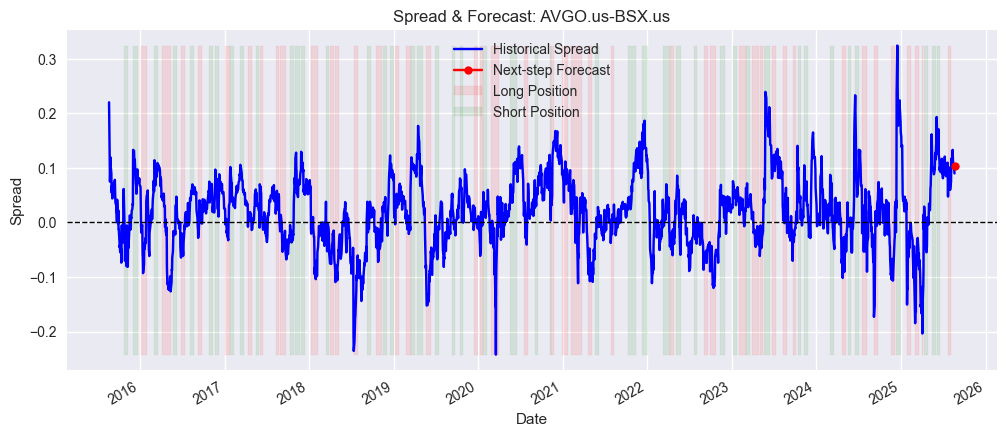

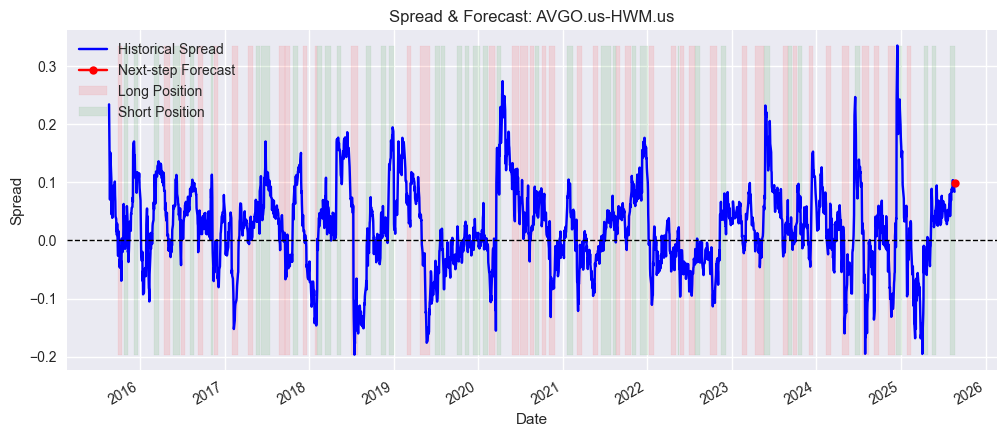

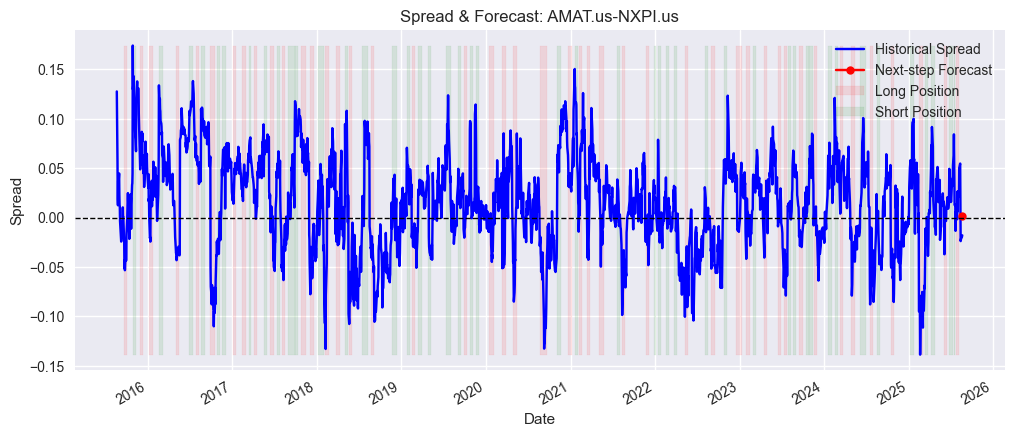

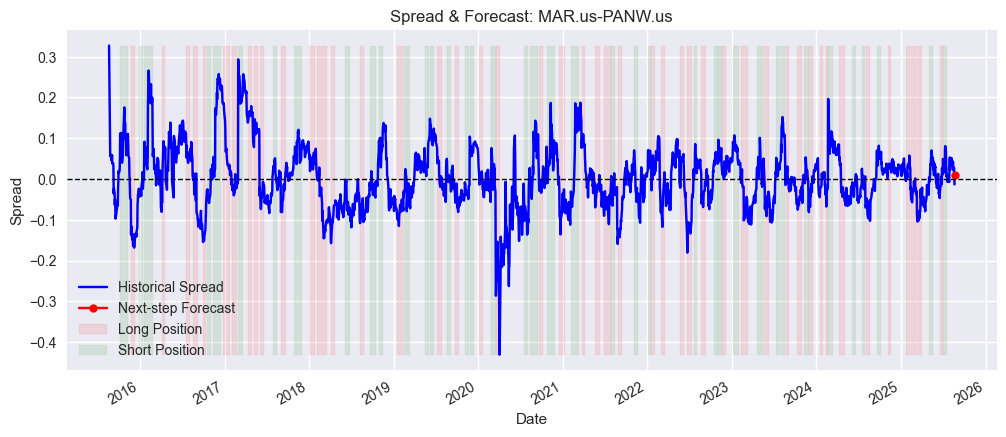

In [14]:
import matplotlib.pyplot as plt

for r in results:
    spread = r['Spread']
    z_score = r['Z_Score']
    pred_spread = r['Pred_Spread']
    position = r['Position']
    
    plt.figure(figsize=(12,5))
    
    # Historical spread
    spread.plot(label='Historical Spread', color='blue')
    
    # Forecasted next-step spread (shifted to align with current step)
    plt.plot(spread.index, [np.nan]*(len(spread)-1) + [pred_spread], 
             marker='o', markersize=6, color='red', label='Next-step Forecast')
    
    # Highlight long/short positions
    plt.fill_between(spread.index, spread.min(), spread.max(), 
                     where=(position==1), color='red', alpha=0.1, label='Long Position')
    plt.fill_between(spread.index, spread.min(), spread.max(), 
                     where=(position==-1), color='green', alpha=0.1, label='Short Position')
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Spread & Forecast: {r['Pair']}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.show()


In [15]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd

results = []

for Y_col, X_col in pairs:
    Y = log_prices[Y_col]
    X = log_prices[X_col]

    # 1️⃣ Dynamic beta & alpha via Kalman filter
    beta_series, alpha_series = kalman_alpha_beta(Y, X, delta=1e-4, obs_var=1.0)
    spread = Y - (alpha_series + beta_series * X)

    # 2️⃣ Half-life of mean reversion
    spread_lag = spread.shift(1).dropna()
    delta_spread = (spread - spread_lag).dropna()
    spread_lag = spread_lag[delta_spread.index]
    lambda_ = np.linalg.lstsq(spread_lag.values.reshape(-1, 1), delta_spread.values, rcond=None)[0][0]
    half_life = -np.log(2) / lambda_ if lambda_ < 0 else np.nan
    signal_horizon = int(np.round(half_life)) if not np.isnan(half_life) else 5

    # 3️⃣ Z-score
    z_score = (spread - spread.rolling(rolling_window).mean()) / spread.rolling(rolling_window).std()

    # 4️⃣ Forecast next-step spread
    spread_pred, spread_mean, spread_vol = forecast_spread(spread)
    spread_extended = spread.copy()

    spread_extended = pd.concat([spread_extended, pd.Series([spread_pred], index=[spread.index[-1] + pd.Timedelta(days=1)])])
    # 5️⃣ HMM on spread returns
    spread_returns = spread.diff().dropna().values.reshape(-1,1)
    hmm_model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=2000, tol=1e-1,verbose=True)
    hmm_model.means_ = np.array([[spread_returns.mean()], [spread_returns.mean() + spread_returns.std()]])
    hmm_model.covars_ = np.array([[spread_returns.var()], [spread_returns.var()]])
    hmm_model.fit(spread_returns)
    hidden_states = hmm_model.predict(spread_returns)
    today_state = hidden_states[-1]
    tomorrow_probs = hmm_model.transmat_[today_state]
    P_low, P_high = tomorrow_probs  # low-vol, high-vol

    regime_multiplier = 1 + P_high  # scale factor based on regime probabilities
    # regime_multiplier=0
    entry_z_adj = entry_z * (regime_multiplier)   # increase threshold in high-vol regime
    exit_z_adj = exit_z * (regime_multiplier)
    long_signal = (z_score < -entry_z_adj) & (spread_extended.shift(-1) > spread_extended)
    short_signal = (z_score > entry_z_adj) & (spread_extended.shift(-1) < spread_extended)
    exit_signal = (z_score > -exit_z_adj) & (z_score < exit_z_adj)

    # 7️ Position series with HMM-based scaling
    base_position = pd.Series(0, index=spread.index)
    for t in range(len(spread)):
        if long_signal.iloc[t]:
            end_idx = min(t + signal_horizon, len(spread))
            base_position.iloc[t:end_idx] = 1
        elif short_signal.iloc[t]:
            end_idx = min(t + signal_horizon, len(spread))
            base_position.iloc[t:end_idx] = -1
        elif exit_signal.iloc[t]:
            base_position.iloc[t] = 0

    # Scale position by HMM regime probabilities
    adjusted_position = base_position * (P_low + 0.5 * P_high)
    adjusted_position = adjusted_position.ffill().fillna(0)

    # 8️⃣ Append results
    results.append({
        'Pair': f"{Y_col}-{X_col}",
        'Half_life': half_life,
        'Dynamic_Beta': beta_series,
        'Dynamic_Alpha': alpha_series,
        'Spread': spread,
        'Z_Score': z_score,
        'Position': adjusted_position,
        'Pred_Spread': spread_pred,
        'Pred_Mean': spread_mean,
        'Pred_Vol': spread_vol,
        'HMM_Probs': tomorrow_probs
    })


Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
         1    5307.68698681             +nan
         2    6014.64180690    +706.95482009
         3    6057.59075629     +42.94894939
         4    6131.52282182     +73.93206553
         5    6176.73395570     +45.21113388
         6    6197.42976602     +20.69581033
         7    6208.90487100     +11.47510497
         8    6217.25128749      +8.34641649
         9    6224.30215218      +7.05086469
        10    6230.61764397      +6.31549180
        11    6236.40547023      +5.78782626
        12    6241.76524992      +5.35977969
        13    6246.75315152      +4.98790159
        14    6251.40093775      +4.64778623
        15    6255.72381378      +4.32287603
        16    6259.72591925      +4.00210547
        17    6263.40515366      

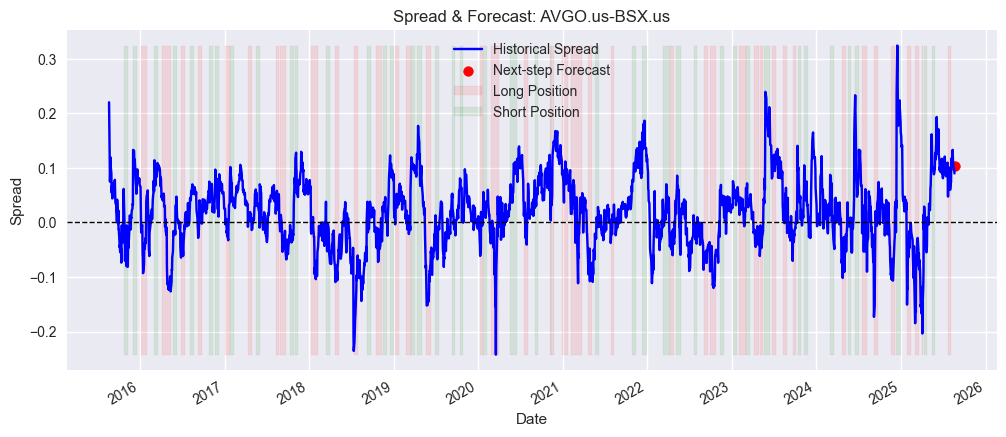

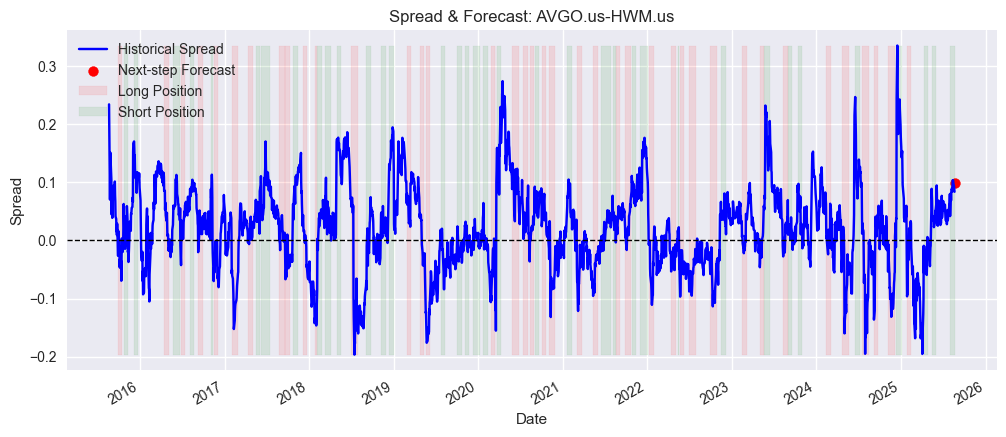

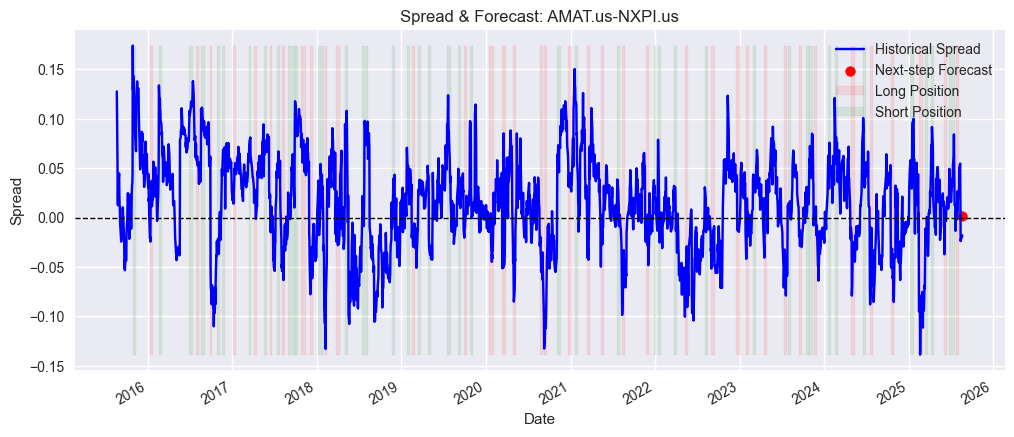

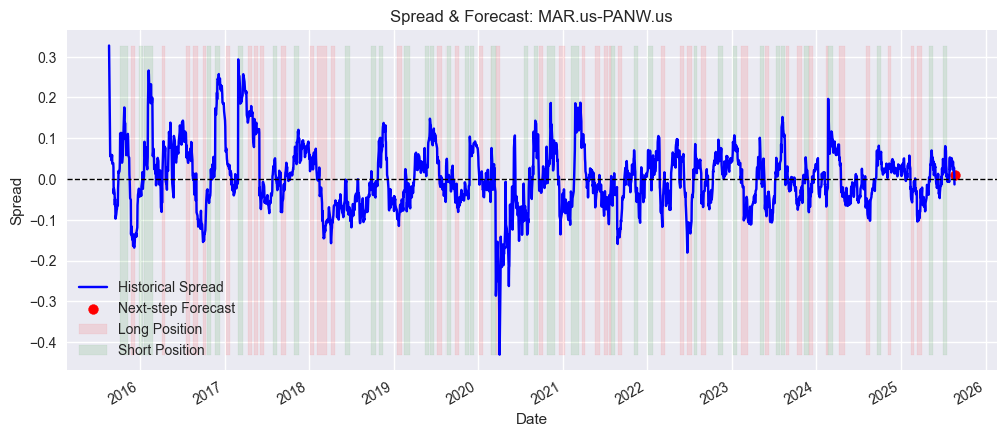

In [16]:
for r in results:
    spread = r['Spread']
    position = r['Position']
    pred_spread = r['Pred_Spread']  # single float in current setup


    plt.figure(figsize=(12,5))

    # Historical spread
    spread.plot(label='Historical Spread', color='blue')

    # Next-step forecast as a point
    plt.scatter(spread.index[-1], pred_spread, color='red', s=50, label='Next-step Forecast')

    # Create binary masks for long/short positions
    long_mask = position > 0.01
    short_mask = position < -0.01

    # Highlight long/short positions
    plt.fill_between(spread.index, spread.min(), spread.max(), where=long_mask,
                     color='red', alpha=0.1, label='Long Position')
    plt.fill_between(spread.index, spread.min(), spread.max(), where=short_mask,
                     color='green', alpha=0.1, label='Short Position')

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Spread & Forecast: {r['Pair']}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.show()


In [17]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\91983\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  4%|▍         | 91/2413 [00:36<18:05,  2.14it/s]C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 16%|█▌        | 380/2413 [03:27<18:45,  1.81it/s]C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer ret

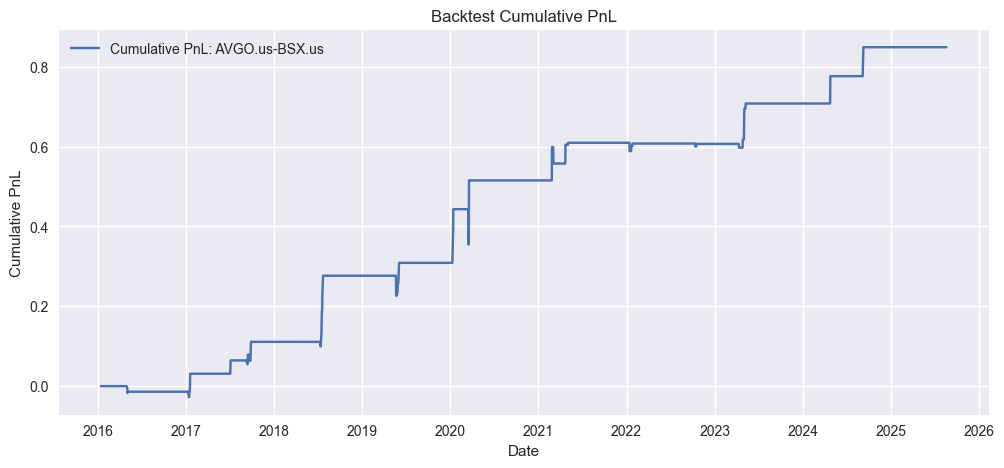

In [23]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm

# Backtest parameters
rolling_window = 100   # Training window for ARMA/GARCH
entry_z = 2.0          # Base z-score entry threshold
exit_z = 0.0          # Exit z-score threshold

backtest_results_z = []

for Y_col, X_col in pairs:
    Y = log_prices[Y_col]
    X = log_prices[X_col]
    
    # Dynamic beta & alpha via Kalman filter
    beta_series, alpha_series = kalman_alpha_beta(Y, X, delta=1e-4, obs_var=1.0)
    spread = Y - (alpha_series + beta_series * X)
    
    positions = []
    pnl_list = []
    
    # Rolling backtest
    for t in tqdm(range(rolling_window, len(spread)-1)):
        train_spread = spread.iloc[t-rolling_window:t]
        
        # 1️⃣ Forecast next-step spread using ARMA/GARCH
        spread_pred, spread_mean, spread_vol = forecast_spread(train_spread)
        
        # 2️⃣ Z-score for current step
        z_score = (train_spread.iloc[-1] - train_spread.mean()) / train_spread.std()
        
        # 3️⃣ HMM on spread returns
        spread_returns = train_spread.diff().dropna().values.reshape(-1,1)
        hmm_model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, tol=1e-1)
        hmm_model.fit(spread_returns)
        hidden_states = hmm_model.predict(spread_returns)
        today_state = hidden_states[-1]
        P_low, P_high = hmm_model.transmat_[today_state]
        
        #  Adjust z-score threshold based on regime
        regime_multiplier = 1 + P_high  # high vol → higher threshold
        adj_entry_z = entry_z * regime_multiplier
        
        #  Generate position for next day
        if z_score < -adj_entry_z and spread_pred > train_spread.iloc[-1]:
            pos = 1  # long
        elif z_score > adj_entry_z and spread_pred < train_spread.iloc[-1]:
            pos = -1  # short
        else:
            pos = 0  # exit / neutral
        positions.append(pos)
        
        # PnL: next-day spread change * position
        spread_next = spread.iloc[t+1]
        pnl = pos * (spread_next - train_spread.iloc[-1])
        pnl_list.append(pnl)
    
    # Convert lists to Series
    position_series = pd.Series(positions, index=spread.index[rolling_window:-1])
    pnl_series = pd.Series(pnl_list, index=spread.index[rolling_window:-1])
    cum_pnl = pnl_series.cumsum()
    
    # Metrics
    sharpe = pnl_series.mean() / pnl_series.std() * np.sqrt(252)
    max_drawdown = (cum_pnl.cummax() - cum_pnl).max()
    
    backtest_results_z.append({
        'Pair': f"{Y_col}-{X_col}",
        'Spread': spread,
        'Position': position_series,
        'PnL': pnl_series,
        'Cumulative_PnL': cum_pnl,
        'Sharpe': sharpe,
        'Max_Drawdown': max_drawdown
    })

# Example: plot cumulative PnL for first pair
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(backtest_results_z[0]['Cumulative_PnL'], label=f"Cumulative PnL: {backtest_results_z[0]['Pair']}")
plt.title("Backtest Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()


In [34]:
# backtest_results_z.to_csv("backtest_results_z.csv", index=False)
backtest_results_z[0]

{'Pair': 'AVGO.us-BSX.us',
 'Spread': date
 2015-08-21    0.220396
 2015-08-24    0.120075
 2015-08-25    0.074872
 2015-08-26    0.089694
 2015-08-27    0.119601
                 ...   
 2025-08-14    0.108802
 2025-08-15    0.103772
 2025-08-18    0.098974
 2025-08-19    0.094397
 2025-08-20    0.090031
 Length: 2514, dtype: float64,
 'Position': date
 2016-01-14    0
 2016-01-15    0
 2016-01-19    0
 2016-01-20    0
 2016-01-21    0
              ..
 2025-08-13    0
 2025-08-14    0
 2025-08-15    0
 2025-08-18    0
 2025-08-19    0
 Length: 2413, dtype: int64,
 'PnL': date
 2016-01-14   -0.0
 2016-01-15   -0.0
 2016-01-19    0.0
 2016-01-20    0.0
 2016-01-21   -0.0
              ... 
 2025-08-13   -0.0
 2025-08-14   -0.0
 2025-08-15   -0.0
 2025-08-18   -0.0
 2025-08-19   -0.0
 Length: 2413, dtype: float64,
 'Cumulative_PnL': date
 2016-01-14   -0.000000
 2016-01-15   -0.000000
 2016-01-19    0.000000
 2016-01-20    0.000000
 2016-01-21    0.000000
                 ...   
 2025-0

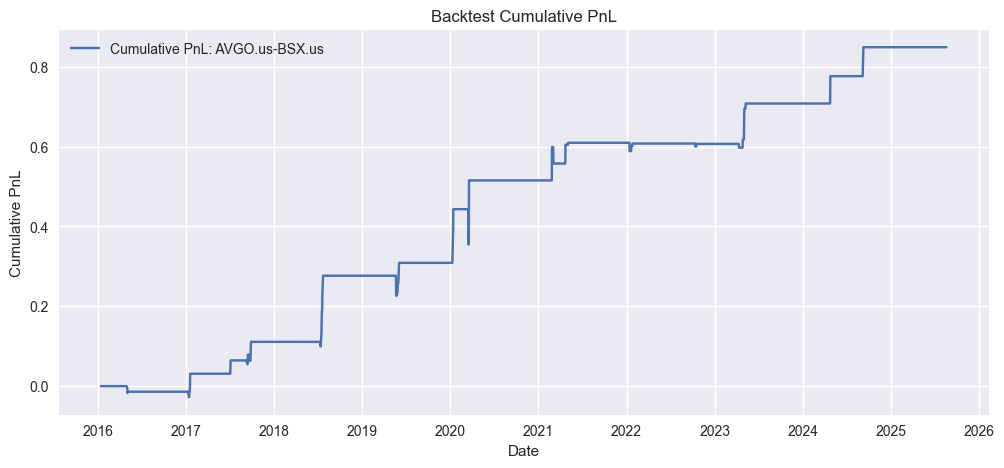

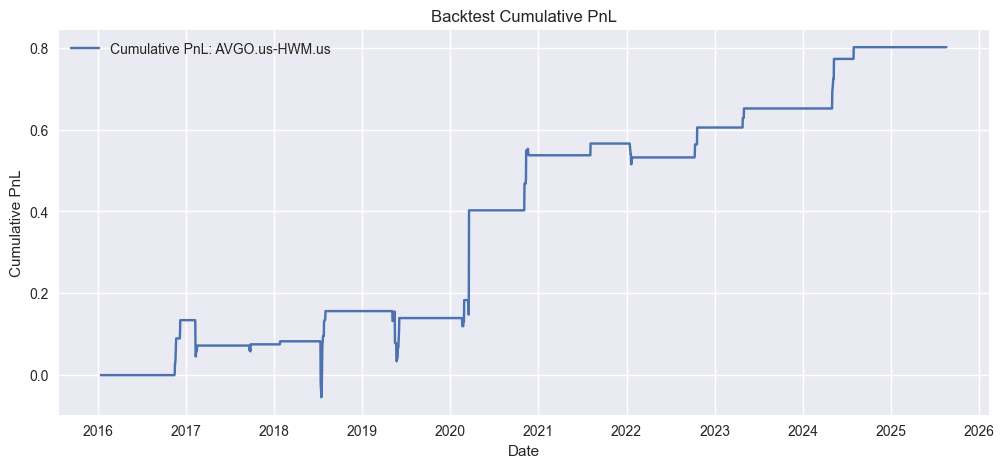

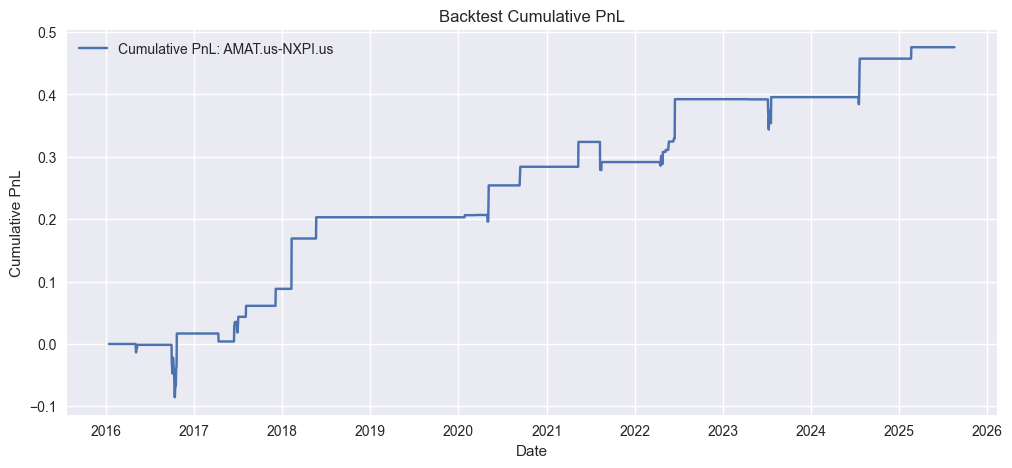

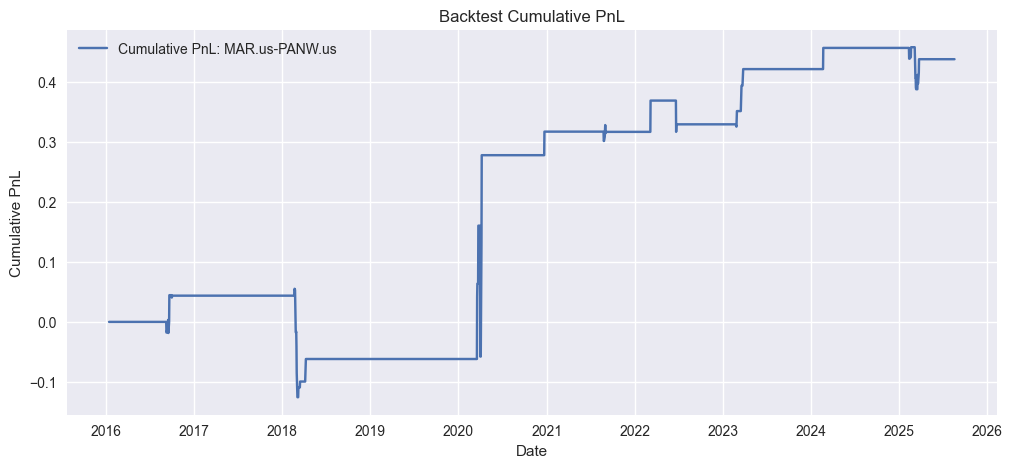

In [27]:
import matplotlib.pyplot as plt
for i in range(0,4):
    plt.figure(figsize=(12,5))
    plt.plot(backtest_results_z[i]['Cumulative_PnL'], label=f"Cumulative PnL: {backtest_results_z[i]['Pair']}")
    plt.title("Backtest Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.legend()
    plt.show()

OU Process Strategy
https://medium.com/@degensugarboo/statistical-arbitrage-in-the-defi-index-2616b77039af

In [20]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# --- Parameters ---
rolling_window = 60      # rolling window for OU + ARMA/GARCH
entry_z = 2.0            # base entry threshold
exit_z = 0.2             # base exit threshold
slippage = 0        # per-trade slippage
transaction_cost = 0.0 # per-trade cost

# Output container
backtest_results = []

for Y_col, X_col in pairs:
    Y = log_prices[Y_col]
    X = log_prices[X_col]

    # 1️⃣ Dynamic hedge ratio
    beta_series, alpha_series = kalman_alpha_beta(Y, X, delta=1e-4, obs_var=1.0)
    spread = Y - (alpha_series + beta_series * X)

    # --- Rolling backtest ---
    positions = []
    pnl = []
    prev_position = 0  # to calculate trade cost

    for t in tqdm(range(rolling_window, len(spread)-1)):
        # --- Rolling window ---
        window_spread = spread.iloc[t-rolling_window:t].dropna()
        
        # --- OU process (s-score) ---
        X1 = window_spread[:-1].values.reshape(-1,1)
        y1 = window_spread[1:].values
        model_ou = LinearRegression().fit(X1, y1)
        a, b = model_ou.intercept_, model_ou.coef_[0]
        residuals = y1 - model_ou.predict(X1)
        kappa = -np.log(b)*252
        m = a / (1-b)
        sigma_eq = np.sqrt(np.var(residuals)/(1-b**2))
        s_score = -(window_spread.iloc[-1] - m)/sigma_eq
        half_life = -np.log(2)/kappa if kappa>0 else 5
        signal_horizon = int(np.round(half_life))

        # --- Forecast next-step spread (optional ARMA/GARCH) ---
        spread_pred, spread_mean, spread_vol = forecast_spread(window_spread)

        # --- HMM regime detection ---
        returns = window_spread.diff().dropna().values.reshape(-1,1)
        hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, tol=1e-2)
        hmm.fit(returns)
        hidden_states = hmm.predict(returns)

        # Determine which state is low/high vol
        state_vars = hmm.covars_.flatten()
        low_vol_state = np.argmin(state_vars)
        high_vol_state = np.argmax(state_vars)
        today_state = hidden_states[-1]
        P_low = hmm.transmat_[today_state, low_vol_state]
        P_high = hmm.transmat_[today_state, high_vol_state]
        regime_multiplier = 1 + P_high

        # --- Adjust thresholds ---
        entry_adj = entry_z * regime_multiplier
        exit_adj  = exit_z * regime_multiplier

        # --- Signals ---
        long_signal  = (s_score < -entry_adj) and (spread_pred > window_spread.iloc[-1])
        short_signal = (s_score > entry_adj)  and (spread_pred < window_spread.iloc[-1])
        exit_signal  = (-exit_adj < s_score < exit_adj)

        # --- Position allocation ---
        pos = 0
        if long_signal:
            pos = 1
        elif short_signal:
            pos = -1
        elif exit_signal:
            pos = 0

        # Scale position by HMM probabilities
        pos_scaled = pos * (P_low + 0.5*P_high)
        positions.append(pos_scaled)

        # --- PnL calculation ---
        spread_next = spread.iloc[t+1]
        trade_cost = abs(pos_scaled - prev_position) * (slippage + transaction_cost)
        pnl_step = pos_scaled * (spread_next - spread.iloc[t]) - trade_cost
        pnl.append(pnl_step)

        prev_position = pos_scaledṁ

    # --- Convert to Series ---
    positions = pd.Series(positions, index=spread.index[rolling_window:-1])
    pnl = pd.Series(pnl, index=spread.index[rolling_window:-1])
    cum_pnl = pnl.cumsum()
    sharpe = pnl.mean()/pnl.std()*np.sqrt(252)
    max_dd = (cum_pnl.cummax() - cum_pnl).max()

    # --- Store results ---
    backtest_results.append({
        'Pair': f"{Y_col}-{X_col}",
        'Spread': spread,
        'Position': positions,
        'PnL': pnl,
        'Cumulative_PnL': cum_pnl,
        'Sharpe': sharpe,
        'Max_Drawdown': max_dd
    })


  5%|▌         | 132/2453 [02:31<44:27,  1.15s/it]  


KeyboardInterrupt: 

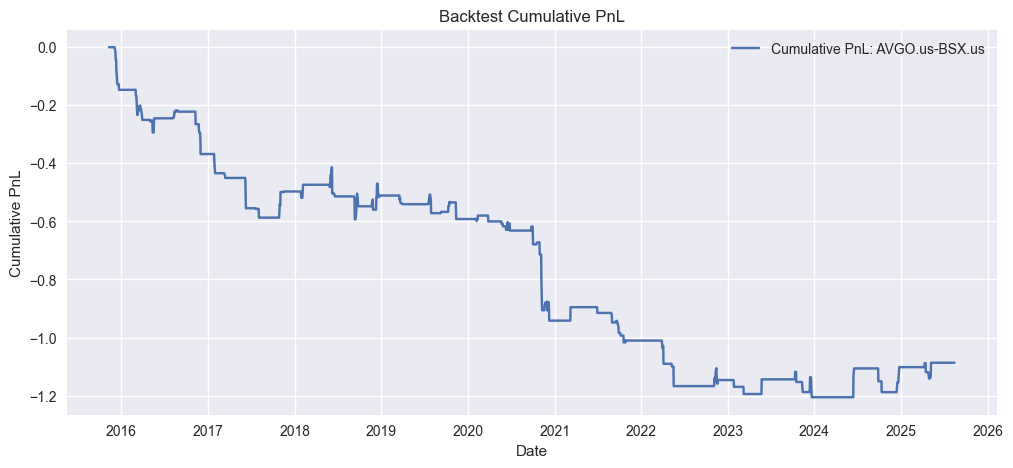

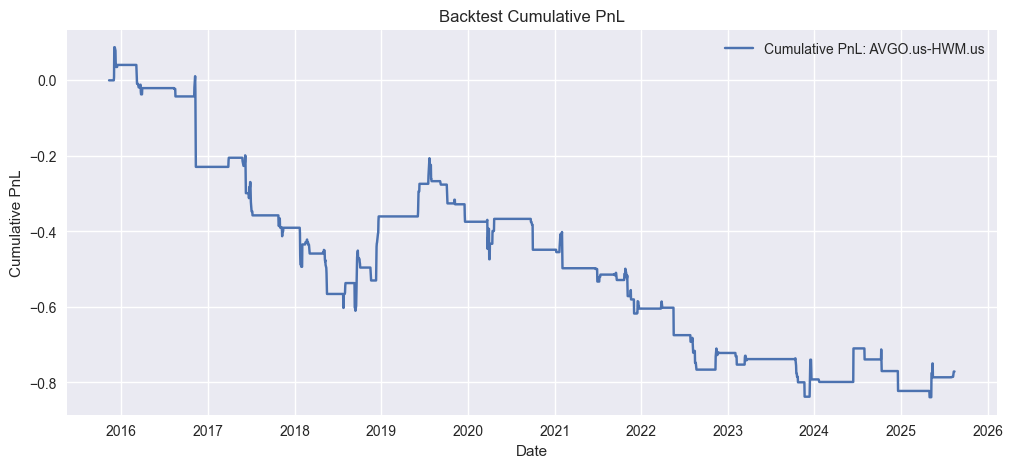

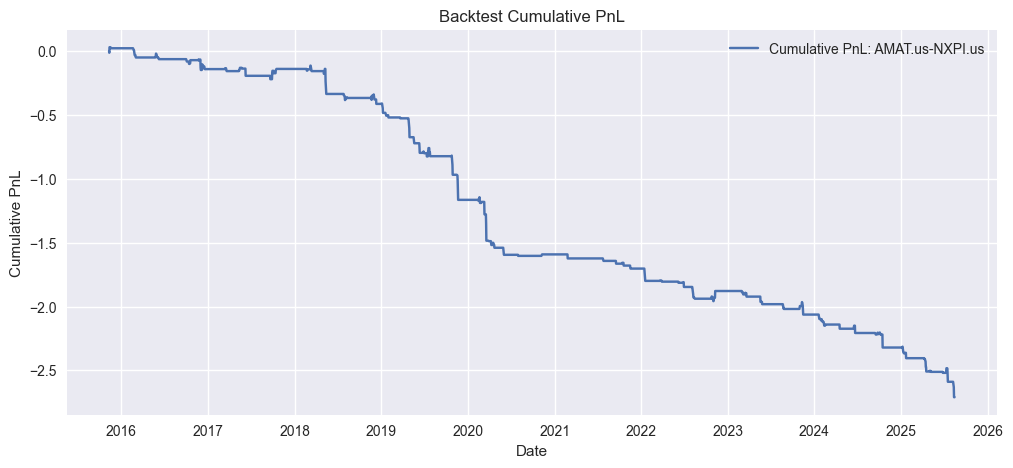

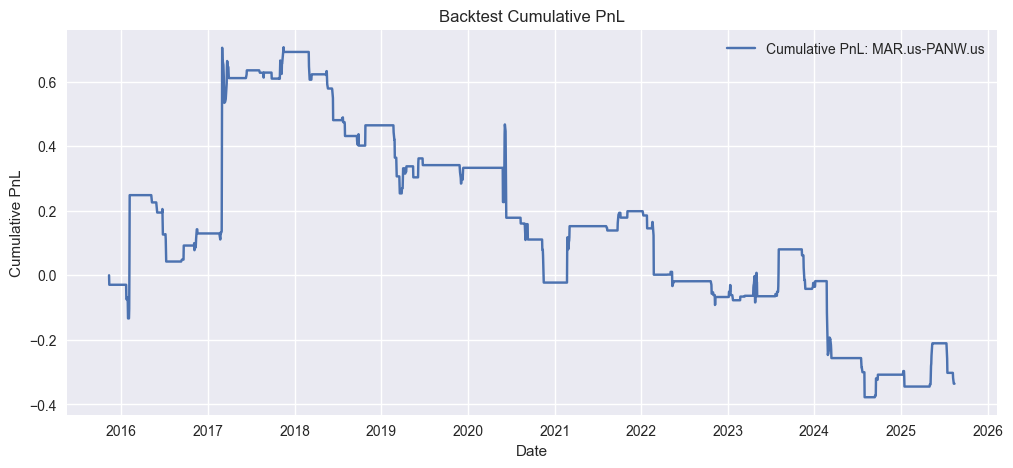

In [ ]:
import matplotlib.pyplot as plt
for i in range(0,4):
    plt.figure(figsize=(12,5))
    plt.plot(backtest_results[i]['Cumulative_PnL'], label=f"Cumulative PnL: {backtest_results[i]['Pair']}")
    plt.title("Backtest Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.legend()
    plt.show()

In [45]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# --- Parameters ---
rolling_window = 100      # rolling window for OU + ARMA/GARCH
entry_z = 2.0            # base entry threshold
exit_z = 0.2             # base exit threshold
slippage = 0        # per-trade slippage
transaction_cost = 0  # per-trade cost

# Output container
backtest_results = []
spread_returns = spread.diff().dropna().values.reshape(-1,1)

# hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, tol=1e-2)
# hmm.fit(spread_returns)

for Y_col, X_col in pairs:
    Y = log_prices[Y_col]
    X = log_prices[X_col]

    # 1️⃣ Dynamic hedge ratio
    beta_series, alpha_series = kalman_alpha_beta(Y, X, delta=1e-4, obs_var=1.0)
    spread = Y - (alpha_series + beta_series * X)

    # --- Rolling backtest ---
    positions = []
    pnl = []
    prev_position = 0  # to calculate trade cost

    for t in tqdm(range(rolling_window, len(spread)-1)):
        # --- Rolling window ---
        window_spread = spread.iloc[t-rolling_window:t].dropna()
        
        # --- OU process (s-score) ---
        X1 = window_spread[:-1].values.reshape(-1,1)
        y1 = window_spread[1:].values
        model_ou = LinearRegression().fit(X1, y1)
        a, b = model_ou.intercept_, model_ou.coef_[0]
        residuals = y1 - model_ou.predict(X1)
        kappa = -np.log(b)*252
        m = a / (1-b)
        sigma_eq = np.sqrt(np.var(residuals)/(1-b**2))
        s_score = (window_spread.iloc[-1] - m)/sigma_eq
        half_life = -np.log(2)/kappa if kappa>0 else 5
        signal_horizon = int(np.round(half_life))

        # --- Forecast next-step spread (optional ARMA/GARCH) ---
        spread_pred, spread_mean, spread_vol = forecast_spread(window_spread)

        # --- HMM regime detection ---
        returns = window_spread.diff().dropna().values.reshape(-1,1)
        hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, tol=1e-2)
        hmm.fit(returns)
        hidden_states = hmm.predict(returns)

        # Determine which state is low/high vol
        state_vars = hmm.covars_.flatten()
        low_vol_state = np.argmin(state_vars)
        high_vol_state = np.argmax(state_vars)
        today_state = hidden_states[-1]
        P_low = hmm.transmat_[today_state, low_vol_state]
        P_high = hmm.transmat_[today_state, high_vol_state]
        regime_multiplier = 1 + P_high

        # --- Adjust thresholds ---
        entry_adj = entry_z * regime_multiplier
        exit_adj  = exit_z * regime_multiplier

        # --- Signals ---
        long_signal  = (s_score < -entry_adj) and (spread_pred > window_spread.iloc[-1])
        short_signal = (s_score > entry_adj)  and (spread_pred < window_spread.iloc[-1])
        exit_signal  = (-exit_adj < s_score < exit_adj)

        # --- Position allocation ---
        pos = 0
        if long_signal:
            pos = 1
        elif short_signal:
            pos = -1
        elif exit_signal:
            pos = 0

        # Scale position by HMM probabilities
        pos_scaled = pos * (P_low + 0.5*P_high)
        positions.append(pos_scaled)

        # --- PnL calculation ---
        spread_next = spread.iloc[t+1]
        # trade_cost = abs(pos_scaled - prev_position) * (slippage + transaction_cost)
        pnl_step = pos_scaled * (spread_next - spread.iloc[t])
        pnl.append(pnl_step)

        prev_position = pos_scaled

    # --- Convert to Series ---
    positions = pd.Series(positions, index=spread.index[rolling_window:-1])
    pnl = pd.Series(pnl, index=spread.index[rolling_window:-1])
    cum_pnl = pnl.cumsum()
    sharpe = pnl.mean()/pnl.std()*np.sqrt(252)
    max_dd = (cum_pnl.cummax() - cum_pnl).max()

    # --- Store results ---
    backtest_results.append({
        'Pair': f"{Y_col}-{X_col}",
        'Spread': spread,
        'Position': positions,
        'PnL': pnl,
        'Cumulative_PnL': cum_pnl,
        'Sharpe': sharpe,
        'Max_Drawdown': max_dd
    })


  4%|▍         | 91/2413 [01:04<25:31,  1.52it/s]C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Model is not converging.  Current: 272.9464951338283 is not greater than 272.95417775133546. Delta is -0.007682617507157374
 16%|█▌        | 380/2413 [22:09<52:47,  1.56s/it]C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2

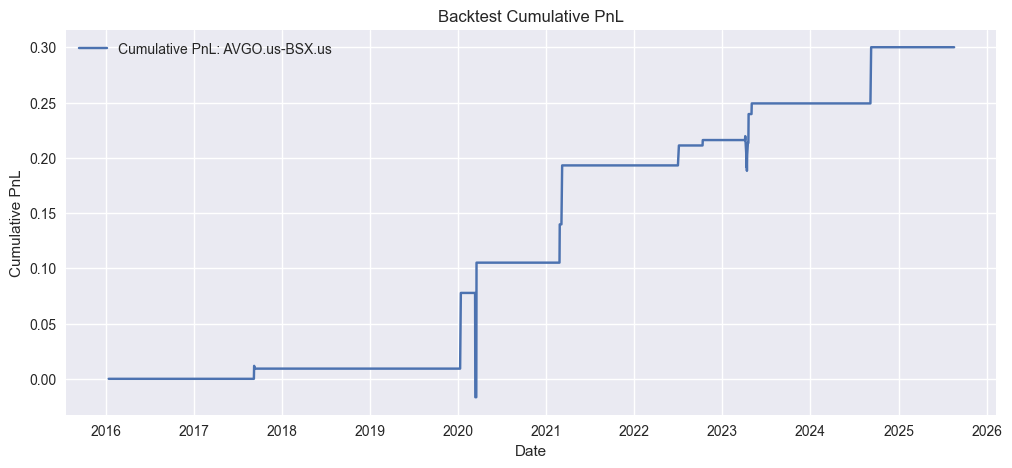

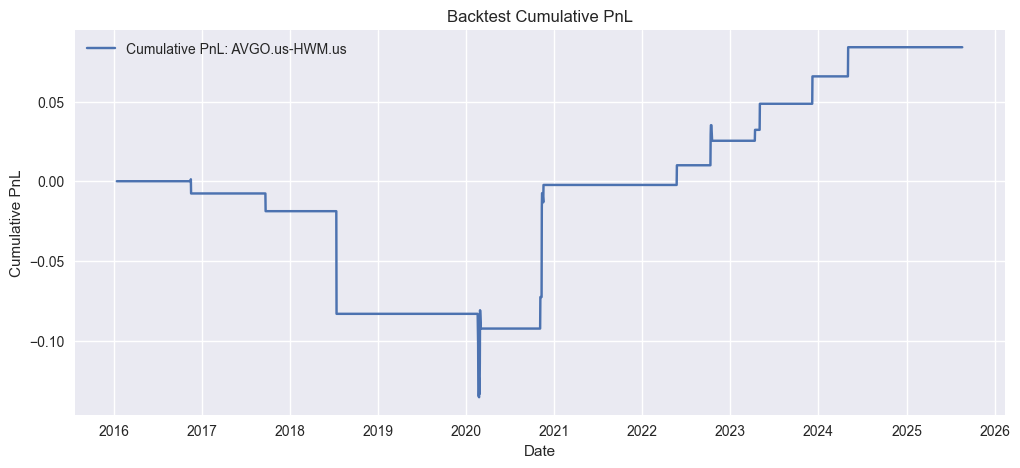

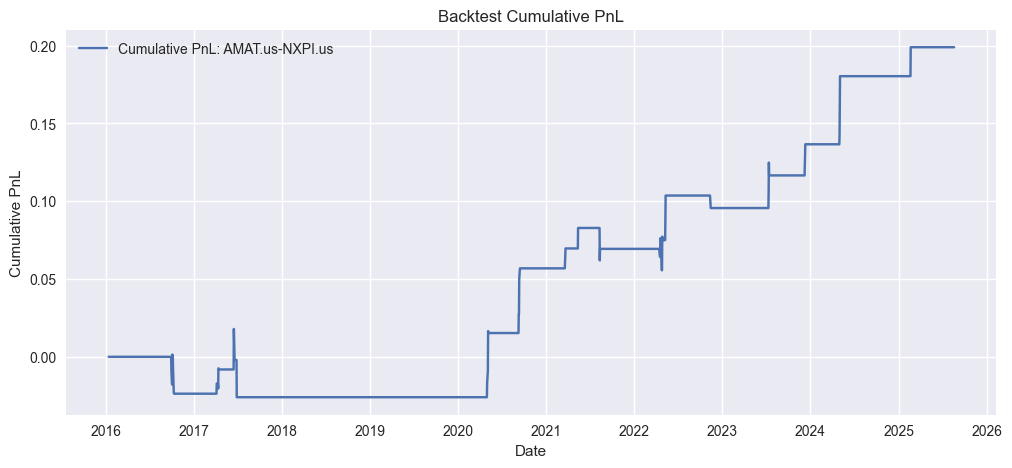

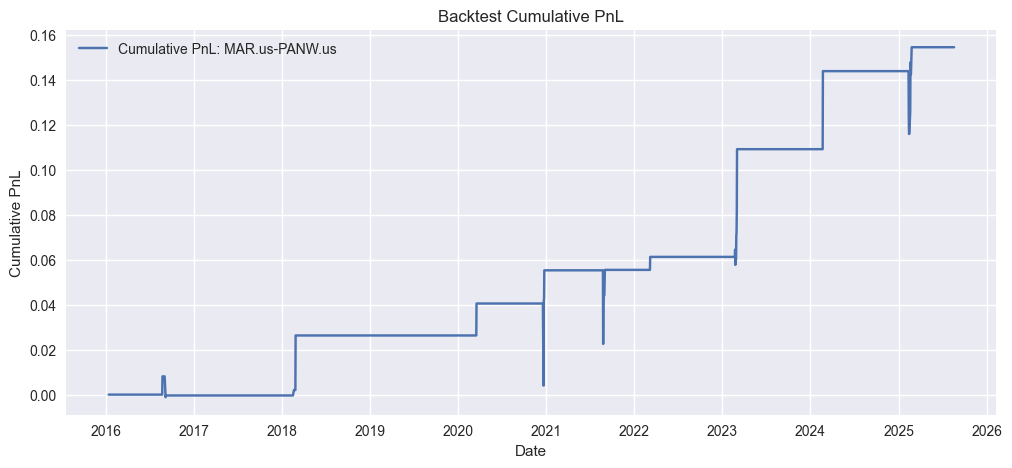

In [46]:
import matplotlib.pyplot as plt
for i in range(0,4):
    plt.figure(figsize=(12,5))
    plt.plot(backtest_results[i]['Cumulative_PnL'], label=f"Cumulative PnL: {backtest_results[i]['Pair']}")
    plt.title("Backtest Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.legend()
    plt.show()

In [58]:
backtest_results[2]

{'Pair': 'AMAT.us-NXPI.us',
 'Spread': date
 2015-08-21    0.127742
 2015-08-24    0.056709
 2015-08-25    0.018796
 2015-08-26    0.012501
 2015-08-27    0.037162
                 ...   
 2025-08-14   -0.022429
 2025-08-15   -0.021212
 2025-08-18   -0.020062
 2025-08-19   -0.018975
 2025-08-20   -0.017948
 Length: 2514, dtype: float64,
 'Position': date
 2016-01-14    0.0
 2016-01-15    0.0
 2016-01-19    0.0
 2016-01-20    0.0
 2016-01-21    0.0
              ... 
 2025-08-13    0.0
 2025-08-14    0.0
 2025-08-15    0.0
 2025-08-18    0.0
 2025-08-19    0.0
 Length: 2413, dtype: float64,
 'PnL': date
 2016-01-14    0.0
 2016-01-15    0.0
 2016-01-19   -0.0
 2016-01-20    0.0
 2016-01-21   -0.0
              ... 
 2025-08-13    0.0
 2025-08-14    0.0
 2025-08-15    0.0
 2025-08-18    0.0
 2025-08-19    0.0
 Length: 2413, dtype: float64,
 'Cumulative_PnL': date
 2016-01-14    0.000000
 2016-01-15    0.000000
 2016-01-19    0.000000
 2016-01-20    0.000000
 2016-01-21    0.000000
      

In [38]:
backtest_results.to_csv('backtest_resultsyyyy.csv', index=False)

AttributeError: 'list' object has no attribute 'to_csv'

In [ ]:
backtest_results.to_csv('backtest_resultsyyyyy.csv', index=False)